## NYPD Data

### Imports

In [1]:
# data import
import pickle

# data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
import matplotlib.pyplot as plt

#gaussian filter
from scipy.ndimage import gaussian_filter

### Data Import

In [2]:
pickle_path = ('../raw_data/clean.pickle')
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)

### Sample Selection

In [3]:
inf = df['period'] > datetime(2016, 10, 1, 0, 0, 0)
sup = df['period'] < datetime(2016, 11, 1, 0, 0, 0)
sample = df[ inf & sup ]

### Lat - Long to Array

In [4]:
def from_coord_to_matrix(df):
    #add 'time_index' column to df
    ind = {time:index for index,time in enumerate(np.sort(df['period'].unique()))}
    df['time_index'] = df['period'].map(ind)
    #initiate matrix
    grid_offset = np.array([0, -74.25559136315213, 40.49611539518921]) # Where do you start
    grid_spacing = np.array([1, 0.005, 0.005]) # What's the space you consider (euclidian here)
    #get points coordinates
    coords = np.array([(t_ind, lon, lat) for t_ind, lon, lat \
                   in zip(df['time_index'],df['longitude'],df['latitude'])])
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    #virgin matrix
    a = np.zeros((indexes[:,0].max()+1, indexes[:,1].max()+1, indexes[:,2].max()+1))
    Z = indexes[:,0]
    X = indexes[:,1]
    Y = indexes[:,2]
    a[Z, X, Y]=1
    return a

In [5]:
img = from_coord_to_matrix(sample)

<ipython-input-4-b7369d75031f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_index'] = df['period'].map(ind)


### Plotting Array (with and w/o Gaussian filter)

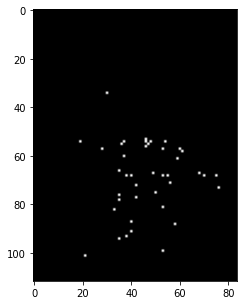

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(img[3], cmap='gray');

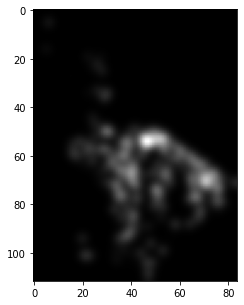

In [7]:
img3D_conv = gaussian_filter(img, sigma=(2, 2, 2))

plt.figure(figsize=(5, 5))

plt.imshow(img3D_conv[3], cmap='gray');

### Splitting into X and y

In [8]:
def get_observation_target(img3D_conv):
    
    position = np.random.randint(0, img3D_conv.shape[0] - 12)
    
    observation = img3D_conv[position:position + 8]
    
    target = img3D_conv[position + 8:position + 12].flatten()
    
    return observation, target

### Subsampling to get multiple X and y

In [9]:
def get_X_y(img3D_conv, number_of_observations):
    
    X = []
    y = []
    
    for n in range(number_of_observations):
        X_subsample, y_subsample = get_observation_target(img3D_conv)
        X.append(X_subsample)
        y.append(y_subsample)
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [10]:
X, y = get_X_y(img3D_conv, 10)

## Model

### Imports

In [11]:
# Train, test, split
from sklearn.model_selection import train_test_split

# Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

### Train, test, split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Model

In [21]:
def model():
    
    model = models.Sequential()

    model.add(layers.GaussianNoise(stddev = 2.5, input_shape = (8, 112, 84)))
    
    model.add(layers.Conv2D(64, kernel_size = 3, activation = 'relu'))
    
    model.add(layers.Conv2D(32, kernel_size = 3, activation = 'relu'))

    model.add(layers.Conv2D(16, kernel_size = 3, activation = 'relu'))

    model.add(layers.Flatten())

    model.add(layers.Dense(4 * 112 * 84))

    model.compile(loss = 'mse',
                      optimizer = 'adam',
                      metrics = 'mae')
    
    return model

### Running Model (Instance, Early Stopping, Fit and Evaluate)

**Reminders**

**batch_size:** no. of data used to compute error between y_pred and y_true each time weights of neural network updated (use 16 or 32)

**epoch:** once all data has been used once to update the weights

In [22]:
model = model()

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 8, 112, 84)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 110, 64)        48448     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 108, 32)        18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 106, 16)        4624      
_________________________________________________________________
flatten_2 (Flatten)          (None, 3392)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 37632)             127685376 
Total params: 127,756,912
Trainable params: 127,756,912
Non-trainable params: 0
________________________________________

In [23]:
es = EarlyStopping(patience = 30, restore_best_weights=True)

model.fit(X_train, y_train,
          batch_size = 16, 
          epochs = 100,
          validation_split = 0.3,
          callbacks = es)

Epoch 1/100
1/1 [==============================] - 1s 509ms/step - loss: 0.4174 - mae: 0.5154 - val_loss: 1.5340e-04 - val_mae: 0.0069
Epoch 2/100
1/1 [==============================] - 0s 426ms/step - loss: 1.4220 - mae: 1.1269 - val_loss: 1.4559e-04 - val_mae: 0.0059
Epoch 3/100
1/1 [==============================] - 0s 456ms/step - loss: 0.2960 - mae: 0.4605 - val_loss: 1.4450e-04 - val_mae: 0.0057
Epoch 4/100
1/1 [==============================] - 0s 84ms/step - loss: 0.0860 - mae: 0.2378 - val_loss: 1.4492e-04 - val_mae: 0.0058
Epoch 5/100
1/1 [==============================] - 0s 85ms/step - loss: 0.0603 - mae: 0.2023 - val_loss: 1.4468e-04 - val_mae: 0.0058
Epoch 6/100
1/1 [==============================] - 0s 372ms/step - loss: 0.0434 - mae: 0.1737 - val_loss: 1.4402e-04 - val_mae: 0.0057
Epoch 7/100
1/1 [==============================] - 0s 374ms/step - loss: 0.0214 - mae: 0.1225 - val_loss: 1.4338e-04 - val_mae: 0.0056
Epoch 8/100
1/1 [==============================] - 0s 371

Epoch 60/100
1/1 [==============================] - 0s 388ms/step - loss: 1.1748e-04 - mae: 0.0051 - val_loss: 1.0426e-04 - val_mae: 0.0048
Epoch 61/100
1/1 [==============================] - 0s 374ms/step - loss: 1.1645e-04 - mae: 0.0051 - val_loss: 1.0338e-04 - val_mae: 0.0048
Epoch 62/100
1/1 [==============================] - 0s 376ms/step - loss: 1.1543e-04 - mae: 0.0051 - val_loss: 1.0250e-04 - val_mae: 0.0048
Epoch 63/100
1/1 [==============================] - 0s 386ms/step - loss: 1.1441e-04 - mae: 0.0050 - val_loss: 1.0163e-04 - val_mae: 0.0048
Epoch 64/100
1/1 [==============================] - 0s 376ms/step - loss: 1.1340e-04 - mae: 0.0050 - val_loss: 1.0076e-04 - val_mae: 0.0047
Epoch 65/100
1/1 [==============================] - 0s 375ms/step - loss: 1.1238e-04 - mae: 0.0050 - val_loss: 9.9897e-05 - val_mae: 0.0047
Epoch 66/100
1/1 [==============================] - 0s 377ms/step - loss: 1.1138e-04 - mae: 0.0049 - val_loss: 9.9039e-05 - val_mae: 0.0047
Epoch 67/100
1/1 [==

In [24]:
print(model.evaluate(X_test, y_test))

1/1 [==============================] - 0s 2ms/step - loss: 8.6358e-05 - mae: 0.0041
[8.635756239527836e-05, 0.004130907356739044]
